In [1]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
import numpy as np
from scipy.sparse import csr_matrix
from scipy import cluster
import scipy.io
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import confusion_matrix
import copy
from scipy.cluster.hierarchy import dendrogram
from scipy import sparse
import pandas as pd
import pickle

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import csv

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

sns.set_theme(style="ticks")

In [2]:
"""
companies is the name of companies
"""
ICB_codes = pickle.load(open("ICB_codes.pickle", 'rb'))
yahoo_codes = pickle.load(open("yahoo_codes.pickle", 'rb'))

def getICBtruth(companies, codetype = "Supersector Code"):
   
    truth = []

    for c in companies:
        code = ICB_codes[codetype].get(c, -1)
        s = int(code)
        truth.append(s)
    return np.array(truth)

def getYahootruth(companies):
   
    truth = []

    for c in companies:
        code = yahoo_codes.get(c, -1)
#         s = int(code)
        truth.append(code)
    return np.array(truth)

In [3]:
ICB_codes.keys()

dict_keys(['Supersector Code', 'Industry Code', 'Sector Code', 'Subsector Code'])

In [4]:
companies = pd.read_csv("./datasets/stockdata1319/components.csv", header=None)[0].to_numpy()

In [5]:
len(companies)

2440

In [6]:
# supersector_dict = {1010: 0,
#  1510: 1,
#  2010: 2,
#  3010: 3,
#  3020: 4,
#  3030: 5,
#  3510: 6,
#  4010: 7,
#  4020: 8,
#  4030: 9,
#  4040: 10,
#  4050: 11,
#  4510: 12,
#  4520: 13,
#  5010: 14,
#  5020: 15,
#  5510: 16,
#  5520: 17,
#  6010: 18,
#  6510: 19}
# j = 0
# for i in np.unique(true_labels):
#     supersector_dict[i] = j
#     j=j+1

In [7]:
supersector_dict = {1010: "TECHNOLOGY",
 1510: "TELECOMMUNICATIONS",
 2010: "HEALTH CARE",
 3010: "BANKS",
 3020: "FINANCIAL SERVICES",
 3030: "INSURANCE",
 3510: "REAL ESTATE",
 4010: "AUTOMOBILES & PARTS",
 4020: "CONSUMER PRODUCTS & SERVICES",
 4030: "MEDIA",
 4040: "RETAIL",
 4050: "TRAVEL & LEISURE",
 4510: "FOOD & BEVERAGE",
 4520: "PERSONAL CARE DRUG AND GROCERY STORES",
 5010: "CONSTRUCTION & MATERIALS",
 5020: "INDUSTRIAL GOODS & SERVICES",
 5510: "BASIC RESOURCES",
 5520: "CHEMICALS",
 6010: "ENERGY",
 6510: "UTILITIES"}

In [8]:
industry_dict = {
    10:"TECHNOLOGY",
    15:"TELECOMMUNICATIONS",
    20:"HEALTH CARE",
    30:"FINANCIALS",
    35:"REAL ESTATE",
    40:"CONSUMER DISCRETIONARY",
    45:"CONSUMER STAPLES",
    50:"INDUSTRIALS",
    55:"BASIC MATERIALS",
    60:"ENERGY",
    65:"UTILITIES"
}

In [39]:
def plot(level, years, prefix=1, emb = True, tmfg_k=0):
    k = len(np.unique(list(ICB_codes[level].values())))
    true_labels = getICBtruth(companies, level)
    valid_sector = np.where((true_labels != -1))[0].astype(int)
    # valid_sector = np.where((true_labels != '') & (true_labels != "None"))[0]
    true_labels = true_labels[valid_sector]
    true_companies = companies[valid_sector]
    print(len(true_labels))
    with open('stock_names.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in enumerate(true_companies):
            writer.writerow([key, value])
    
    Z = []
    if emb:
        if prefix==1:
            Z = np.genfromtxt("./outputs/Zs/stock%semb-exact-Z-0" % years)
        else:
            Z = np.genfromtxt("./outputs/Zs/stock%semb-prefix-Z-%s-0" %(years, prefix))
    else:
        if prefix==1:
            Z = np.genfromtxt("./outputs/Zs/stockicb%s-exact-Z-0" % years)
        else:
            Z = np.genfromtxt("./outputs/Zs/stockicb%s-prefix-Z-%s-0" %(years, prefix))
    
    if tmfg_k==0:
        tmfg_k = k
    tmfg_clustering = scipy.cluster.hierarchy.cut_tree(Z, n_clusters=[tmfg_k]).flatten().astype(str)
    
#     tmfg_clustering = tmfg_clustering[valid_sector]
    print(adjusted_rand_score(tmfg_clustering, true_labels))
    
    stockdf = pd.DataFrame(np.array([np.array(true_labels), 
                             tmfg_clustering]).transpose()
                        , columns = ['true','tmfg'])
    f, ax = plt.subplots(figsize=(20, 9))

    g = sns.histplot(
        stockdf,
        x="tmfg", hue="true",
        multiple="stack",
        palette="gist_ncar",#"gist_rainbow",
        edgecolor=".3",
#         bins=k,binwidth=1
        ax = ax,
        )
        
#     hatches = ['+', '\\', '/',  '*', '-', 'x', '.', 'o', 'O', '|', '|', '|', '|', '|']

#     # Loop over the bars
#     for i,thisbar in enumerate(ax.patches):
#         if(i < 10):
#             thisbar.set_hatch(hatches[i])
        
    ax.set_xticks(np.array(list(range(tmfg_k))));
    ax.set_xticklabels(np.array(list(range(tmfg_k)))+1);
#     ax.set_xlim(-1,)
    ax.set_xlabel("PAR-TDBHT Clusters", fontsize = 30)
    ax.set_ylabel("Count", fontsize = 30)
    
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(30)
    # plt.legend(bbox_to_anchor=([1, 1]), fontsize = 15)#title='supersectors', 
    if level=="Supersector Code":
        for t in g.legend_.texts:
            t.set_text(supersector_dict[int(t.get_text())])
    if level=="Industry Code":
        for t in g.legend_.texts:
            t.set_text(industry_dict[int(t.get_text())])
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, fontsize = 25, title_fontsize=30, frameon=False, title=level)
    return f

1614
0.3612377104679966


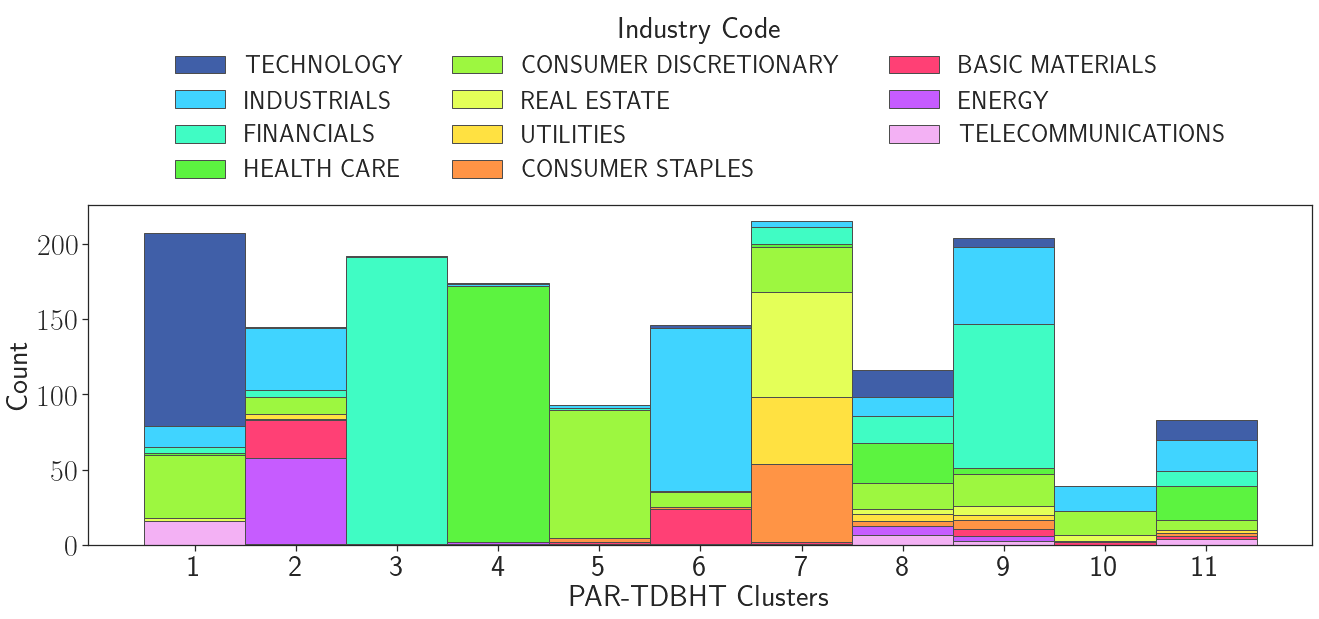

In [40]:
f = plot("Industry Code", 1319, 30)##emb
# plt.tight_layout()
f.subplots_adjust(left = 0.1, right = 0.95, top=0.65)
f.savefig("../figures/stock.pdf")

1614
0.2784735506378764


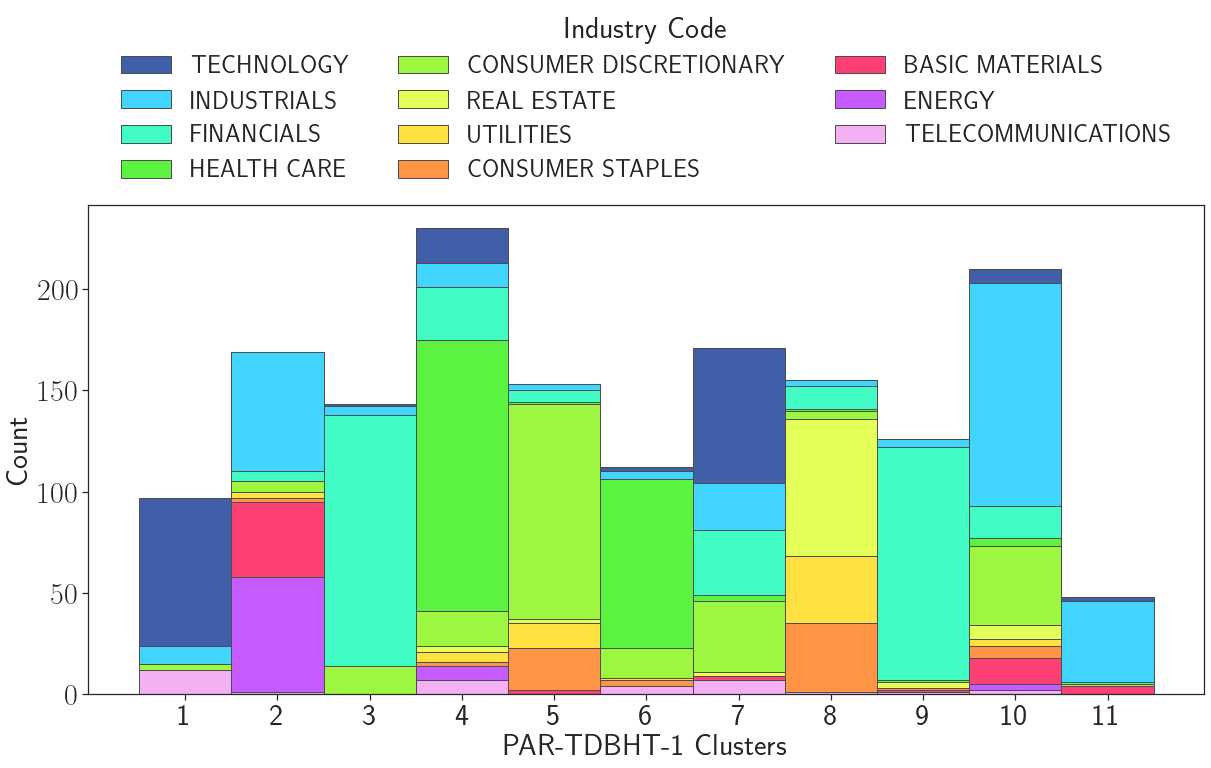

In [38]:
plot("Industry Code", 1319, 1)
f.subplots_adjust(left = 0.1, right = 0.95, top=0.65)
f.savefig("../figures/stock-1.pdf")

1614


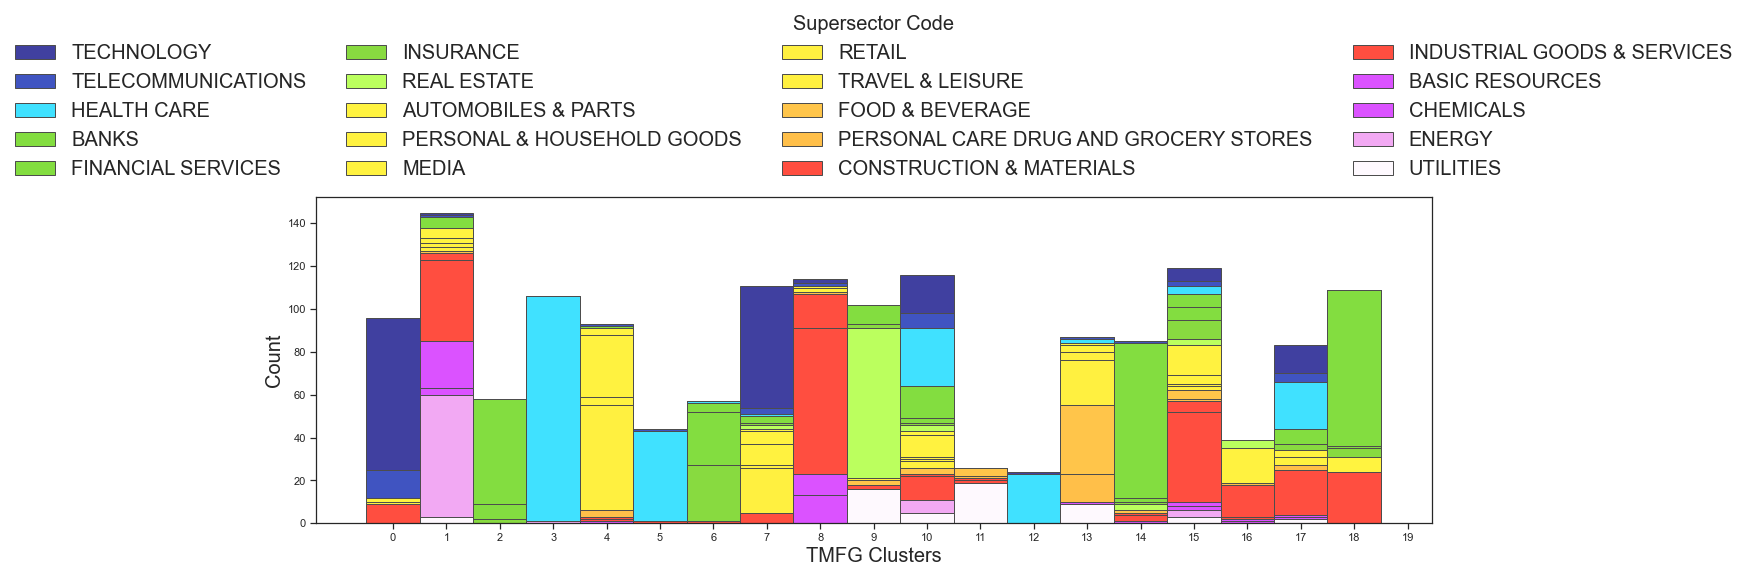

In [143]:
ax = plot("Supersector Code", 1319, 30,True)##emb

1614


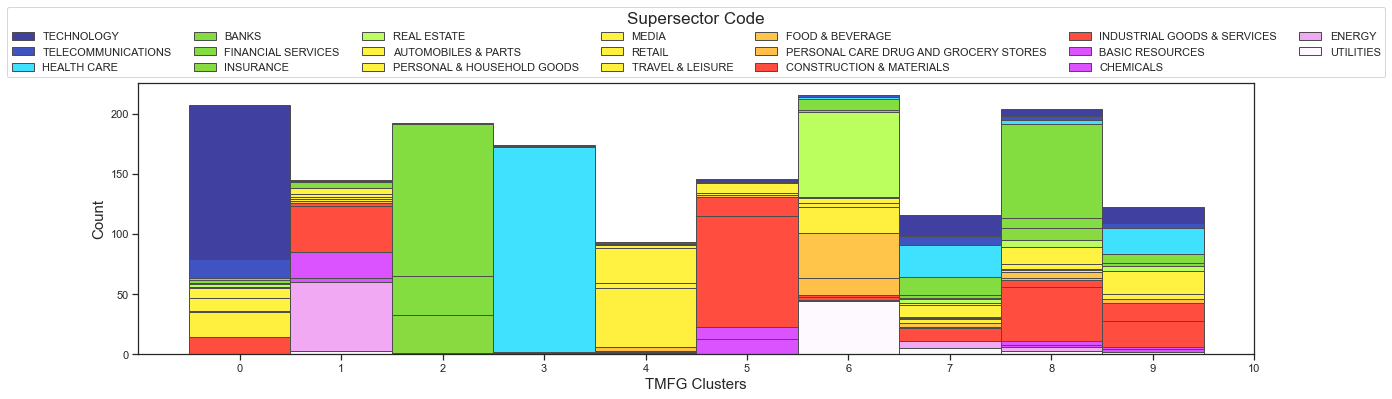

In [118]:
ax = plot("Supersector Code", 1319, 30,True,11)##emb

1614


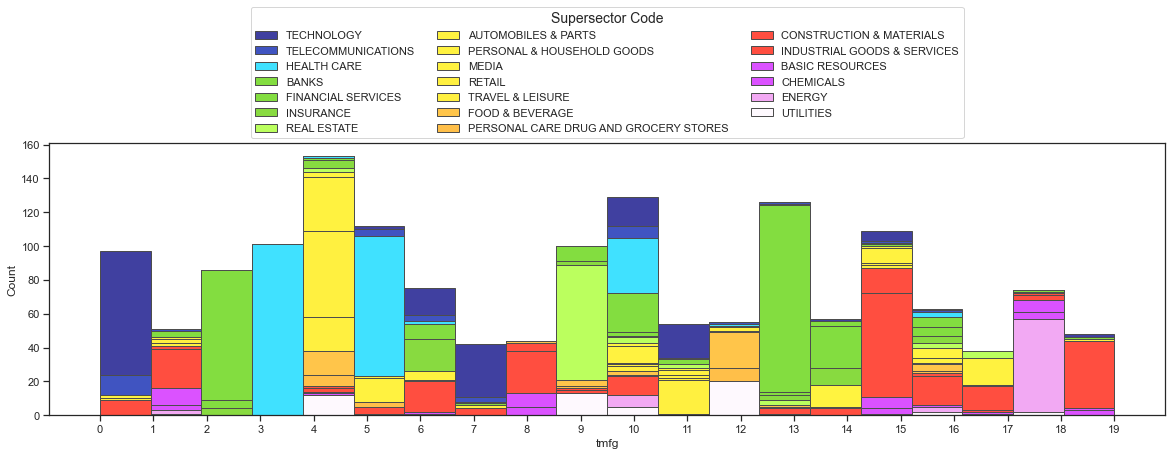

In [54]:
plot("Supersector Code", 1319) ##emb

1614


<AxesSubplot:xlabel='TMFG Clusters', ylabel='Count'>

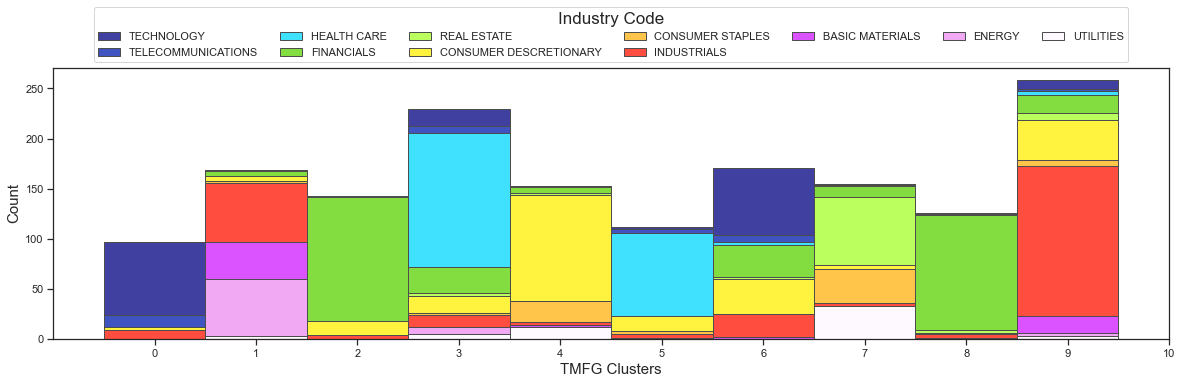

In [119]:
plot("Industry Code", 1319) ##emb

1614


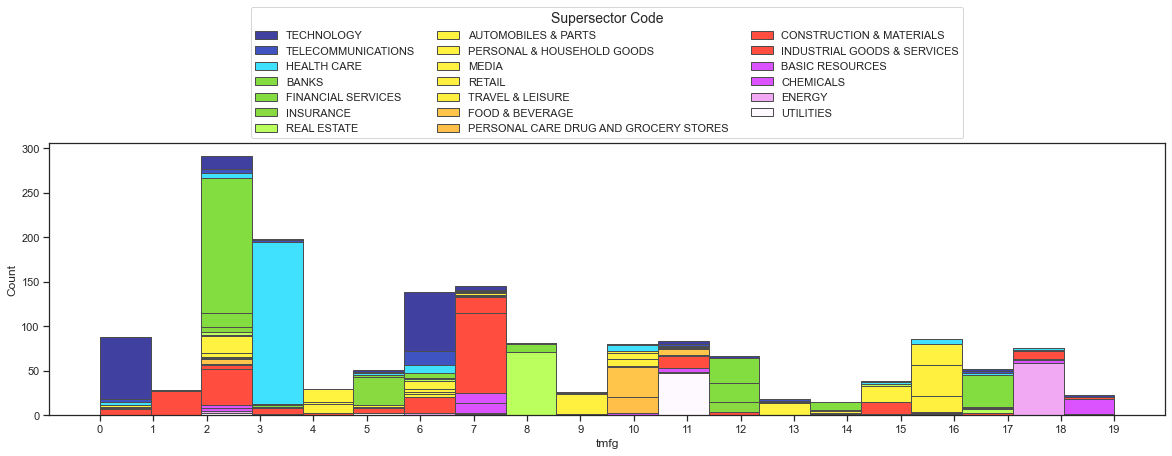

In [50]:
plot("Supersector Code", 1319)

1614


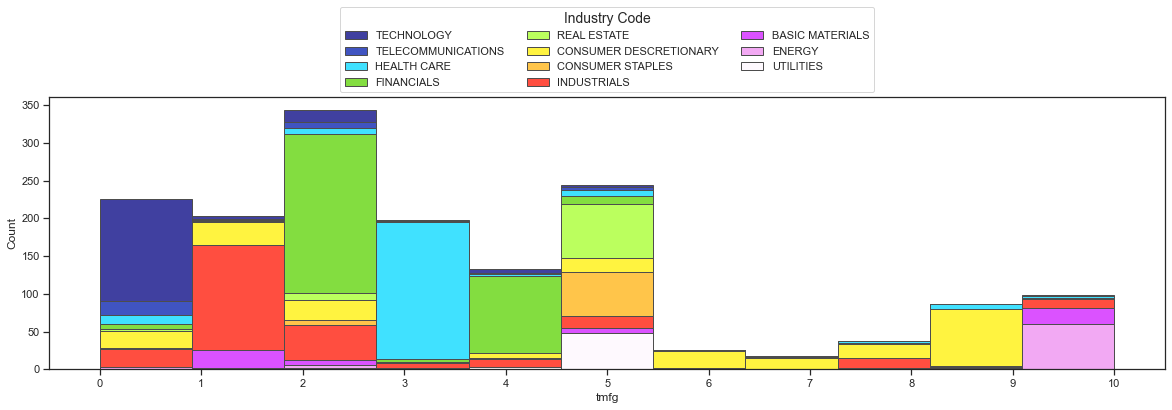

In [51]:
plot("Industry Code", 1319)

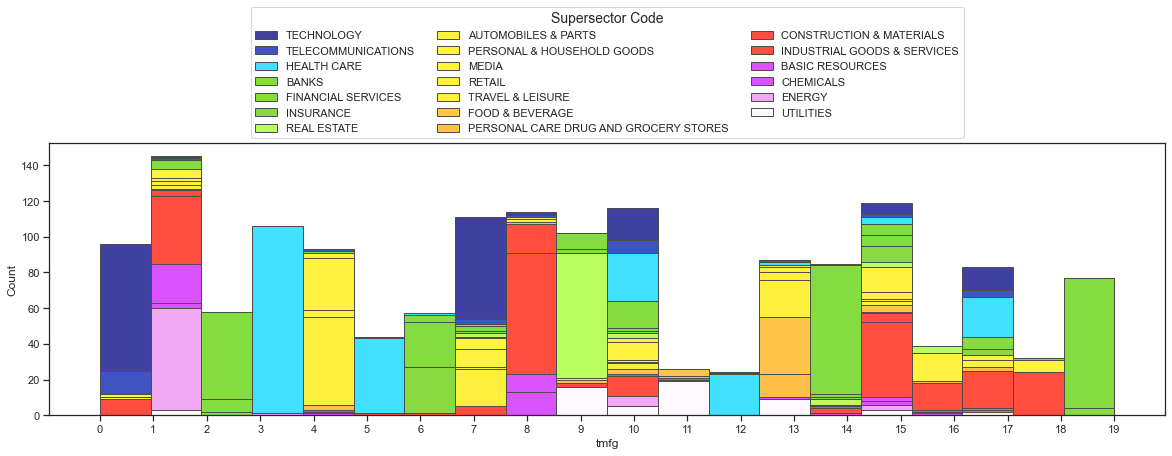

In [42]:
plot("Supersector Code", 1319, 30)

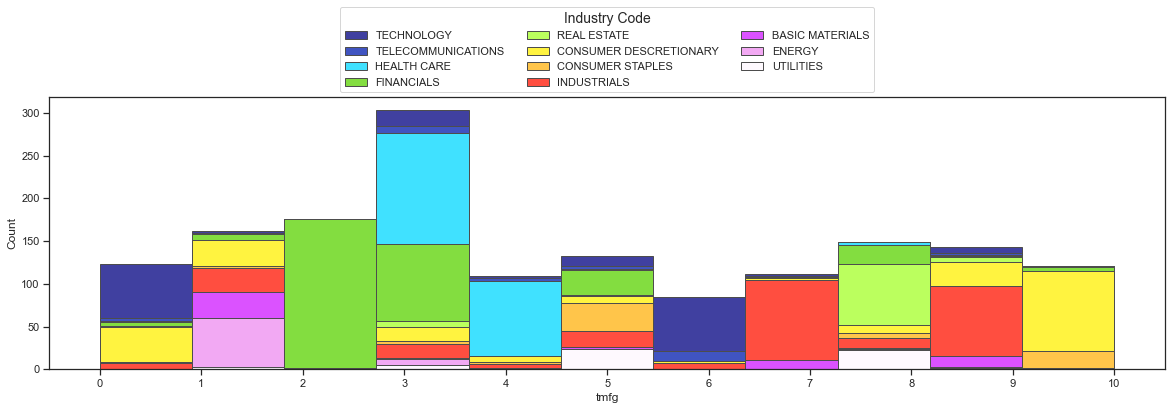

In [41]:
plot("Industry Code", 1319, 10)

In [46]:
for i in [1,2,3,4]:
    for j in [1,2,3,4]:
        if(j > i):
            print("(v_%s, v_%s)" % (i,j))

(v_1, v_2)
(v_1, v_3)
(v_1, v_4)
(v_2, v_3)
(v_2, v_4)
(v_3, v_4)
